In [331]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib

import lightgbm as lgb
import utils

#supression warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load data

In [332]:
data_path = './data/jlr_all_user_processed.xlsx'
df = pd.read_excel(data_path)
df.head(3)

,user_id,follow_count,fans_count,gender,birthday,location,level,registration_time,properties,mileage,...,car_friend_zone,label,car_like,excellent_post_count,all_post_count,regis_year,regis_month,regis_day,date,date_delta
0,oden123,0,0,2,NaT,1,1,2018-03-26,1,4430,...,NaN,True,1,0,0,2018,3,3,2018-03-26,4522
1,生活1934626,2,4,2,NaT,2,1,2012-05-07,1,4270,...,"[{'名称': '汽车之家甘肃论坛车友会', '人数': 672, '创建时间': '201...",True,2,0,0,2012,5,5,2012-05-07,2373
2,wangzi1125,0,1,2,NaT,3,1,2017-06-18,1,2090,...,NaN,True,3,0,1,2017,6,6,2017-06-18,4241


In [333]:
df.keys()

Index(['user_id', 'follow_count', 'fans_count', 'gender', 'birthday',
       'location', 'level', 'registration_time', 'properties', 'mileage',
       'post', 'cars', 'koubei_post', 'gas_mileage', 'car_friend_zone',
       'label', 'car_like', 'excellent_post_count', 'all_post_count',
       'regis_year', 'regis_month', 'regis_day', 'date', 'date_delta'],
      dtype='object')

In [334]:
df.dtypes

user_id                         object
follow_count                     int64
fans_count                       int64
gender                           int64
birthday                datetime64[ns]
location                         int64
level                            int64
registration_time       datetime64[ns]
properties                       int64
mileage                          int64
post                            object
cars                            object
koubei_post                     object
gas_mileage                     object
car_friend_zone                 object
label                             bool
car_like                         int64
excellent_post_count             int64
all_post_count                   int64
regis_year                       int64
regis_month                      int64
regis_day                        int64
date                    datetime64[ns]
date_delta                       int64
dtype: object

### Data choosing  
we choose some features to build the machine learning model

In [335]:
x = df.drop(columns=[
                      'user_id',
#                      'follow_count',
#                      'fans_count', 
#                      'gender', 
                      'birthday',
#                      'location',
#                      'level',
                      'registration_time',
#                      'properties',
#                      'mileage',
                      'post',
                      'cars',
                      'koubei_post',
                      'gas_mileage',
                      'car_friend_zone',
                      'label',
#                      'car_like', 
                     'excellent_post_count',
                     'all_post_count',
                      'regis_year',
                      'regis_month',
                      'regis_day', 
                      'date',
#                      'date_delta'
                     ])
x.head(2)

,follow_count,fans_count,gender,location,level,properties,mileage,car_like,date_delta
0,0,0,2,1,1,1,4430,1,4522
1,2,4,2,2,1,1,4270,2,2373


In [336]:
y = df['label'].astype('uint8')
utils.exploreCat(df, 'label')

In [337]:
# dataset size
_x, _y = np.array(x).astype('int'), np.array(y).astype('int')
_x.shape, _y.shape

((5555, 9), (5555,))

### Split dataset into train/validation/test set
train:validation:test = 8:1:1

In [338]:
x_train, x_test, y_train, y_test = train_test_split(_x, _y, test_size=0.2,  random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5,  random_state = 42)

In [339]:
print(x_train.shape, x_val.shape, x_test.shape)

(4444, 9) (555, 9) (556, 9)


### Build SVM model then train with above dataset

In [340]:
clf = SVC(C=0.8, kernel='rbf', class_weight='balanced')

In [341]:
clf.fit(x_train, y_train)

SVC(C=0.8, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [342]:
pred = clf.predict(x_test)

In [343]:
print(classification_report(y_true=y_test, y_pred=pred))

             precision    recall  f1-score   support

          0       0.85      0.92      0.88       476
          1       0.03      0.01      0.02        80

avg / total       0.73      0.79      0.76       556



### Build lightgbm model and train with above dataset

In [344]:
# Lightgbm dataset construction

# train_data = lgb.Dataset(x_train, label=y_train)
# val_data = lgb.Dataset(x_val, label=y_val)
# test_data = lgb.Dataset(x_test, label = y_test)

feature_name = list(x.keys())
categorical_feature = ['gender',
                       'location',
                       'level', 
                       'properties', 
                       'car_like',
                     #'regis_year', 'regis_month', 'regis_day',
                                            ]
train_data = lgb.Dataset(x_train, 
                         label=y_train,
                         feature_name=feature_name,
                         categorical_feature=categorical_feature,
                        )
val_data = lgb.Dataset(x_val, 
                       label=y_val,
                       feature_name=feature_name,
                       categorical_feature=categorical_feature,
                      )
test_data = lgb.Dataset(x_test, 
                        label = y_test,
                        feature_name=feature_name,
                        categorical_feature=categorical_feature,
                       )
# feature_name, categorical_feature

#### Setting parameters

In [345]:
# param = {'max_depth': 10,
#         'num_leaves': 20,
#         'num_trees': 5,
#         'objective':'binary',
#         'min_data_in_leaf':100}
# param['metric'] = 'auc'

# para searching
params = {
    'boosting_type': 'gbdt',  # np.random.choice(['dart', 'gbdt']),
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'], 
    
    'learning_rate': 0.35,
    
    'num_leaves': np.random.randint(23),
    'max_depth': np.random.randint(7,10),
    'min_data_in_leaf': int(2 ** (np.random.rand()*1.5 + 5)),
    
    'feature_fraction': np.random.rand()*0.35+0.65,
    'bagging_fraction': np.random.rand()*0.35+0.65,
    'bagging_freq': 1,
    
    'lambda_l1': 10 ** (np.random.rand() * 4),
    'lambda_l2': 10 ** (np.random.rand() * 3 + 2),
    'min_gain_to_split': 0.0,
    'min_sum_hessian_in_leaf': 0.1,
    
    'num_threads': 16,
    'verbose': 0,
    'is_training_metric': 'True'
}
print('Hyper-parameters:')
print(params)

Hyper-parameters:
{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': ['binary_logloss', 'auc'], 'learning_rate': 0.35, 'num_leaves': 9, 'max_depth': 9, 'min_data_in_leaf': 54, 'feature_fraction': 0.8999533621202408, 'bagging_fraction': 0.9255611746101705, 'bagging_freq': 1, 'lambda_l1': 11.214826586228723, 'lambda_l2': 289.2294869393507, 'min_gain_to_split': 0.0, 'min_sum_hessian_in_leaf': 0.1, 'num_threads': 16, 'verbose': 0, 'is_training_metric': 'True'}


In [346]:
# params={'boosting_type': 'gbdt',
#         'objective': 'binary',
#         'metric': ['binary_logloss', 'auc'],
#         'learning_rate': 0.35,
#         'num_leaves': 10,
#         'max_depth': 9,
#         'min_data_in_leaf': 100,
#         'feature_fraction': 0.8815622868115178,
#         'bagging_fraction': 0.8390135637666467, 
#         'bagging_freq': 1, 
#         'lambda_l1': 31.388095945215674,
#         'lambda_l2': 9057.459915710713,
#         'min_gain_to_split': 0.0,
#         'min_sum_hessian_in_leaf': 0.1, 
#         'num_threads': 16, 'verbose': 0,
#         'is_training_metric': 'True'}

In [347]:
{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': ['binary_logloss', 'auc'], 'learning_rate': 0.35, 'num_leaves': 16, 'max_depth': 7, 'min_data_in_leaf': 45, 'feature_fraction': 0.7185404231822985, 'bagging_fraction': 0.7205070834554599, 'bagging_freq': 1, 'lambda_l1': 2.3982232376696975, 'lambda_l2': 23817.54011963604, 'min_gain_to_split': 0.0, 'min_sum_hessian_in_leaf': 0.1, 'num_threads': 16, 'verbose': 0, 'is_training_metric': 'True'}

{'bagging_fraction': 0.7205070834554599,
 'bagging_freq': 1,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.7185404231822985,
 'is_training_metric': 'True',
 'lambda_l1': 2.3982232376696975,
 'lambda_l2': 23817.54011963604,
 'learning_rate': 0.35,
 'max_depth': 7,
 'metric': ['binary_logloss', 'auc'],
 'min_data_in_leaf': 45,
 'min_gain_to_split': 0.0,
 'min_sum_hessian_in_leaf': 0.1,
 'num_leaves': 16,
 'num_threads': 16,
 'objective': 'binary',
 'verbose': 0}

#### Training 

In [348]:
evals_result = {}  # dict to store evaluation results of all the items in `valid_sets`

gbm = lgb.train(params, 
                train_data, 
                num_boost_round=10000, 
                valid_sets=[train_data, val_data], 
                valid_names = ['train', 'valid'], 
                evals_result=evals_result, 
                early_stopping_rounds=3000, 
                verbose_eval=300)

Training until validation scores don't improve for 3000 rounds.
[300]	train's auc: 0.91046	train's binary_logloss: 0.241297	valid's auc: 0.733698	valid's binary_logloss: 0.320155
[600]	train's auc: 0.920034	train's binary_logloss: 0.232181	valid's auc: 0.730701	valid's binary_logloss: 0.326983
[900]	train's auc: 0.920034	train's binary_logloss: 0.232181	valid's auc: 0.730701	valid's binary_logloss: 0.326983
[1200]	train's auc: 0.920034	train's binary_logloss: 0.232181	valid's auc: 0.730701	valid's binary_logloss: 0.326983
[1500]	train's auc: 0.920034	train's binary_logloss: 0.232181	valid's auc: 0.730701	valid's binary_logloss: 0.326983
[1800]	train's auc: 0.920034	train's binary_logloss: 0.232181	valid's auc: 0.730701	valid's binary_logloss: 0.326983
[2100]	train's auc: 0.920034	train's binary_logloss: 0.232181	valid's auc: 0.730701	valid's binary_logloss: 0.326983
[2400]	train's auc: 0.920034	train's binary_logloss: 0.232181	valid's auc: 0.730701	valid's binary_logloss: 0.326983
[270

In [349]:
# save best round results to csv
bst_round = np.argmax(evals_result['valid']['auc'])
trn_auc = evals_result['train']['auc'][bst_round]
trn_loss = evals_result['train']['binary_logloss'][bst_round]
val_auc = evals_result['valid']['auc'][bst_round]
val_loss = evals_result['valid']['binary_logloss'][bst_round]

In [356]:
print('Best Round: %d'%bst_round)
print('Training loss: %.5f, Validation loss: %.5f'%(trn_loss, val_loss))
print('Training AUC : %.5f, Validation AUC : %.5f'%(trn_auc, val_auc))

# save model to file
model_save_path = './models/trn_auc' + str(trn_auc)[:5] + '_' + 'val_auc' + str(val_auc)[:5] + '.txt'
print('Save model to file: {}'.format(model_save_path))
gbm.save_model(model_save_path)

Best Round: 60
Training loss: 0.28004, Validation loss: 0.30844
Training AUC : 0.85504, Validation AUC : 0.75502
Save model to file: ./models/trn_auc0.855_val_auc0.755.txt


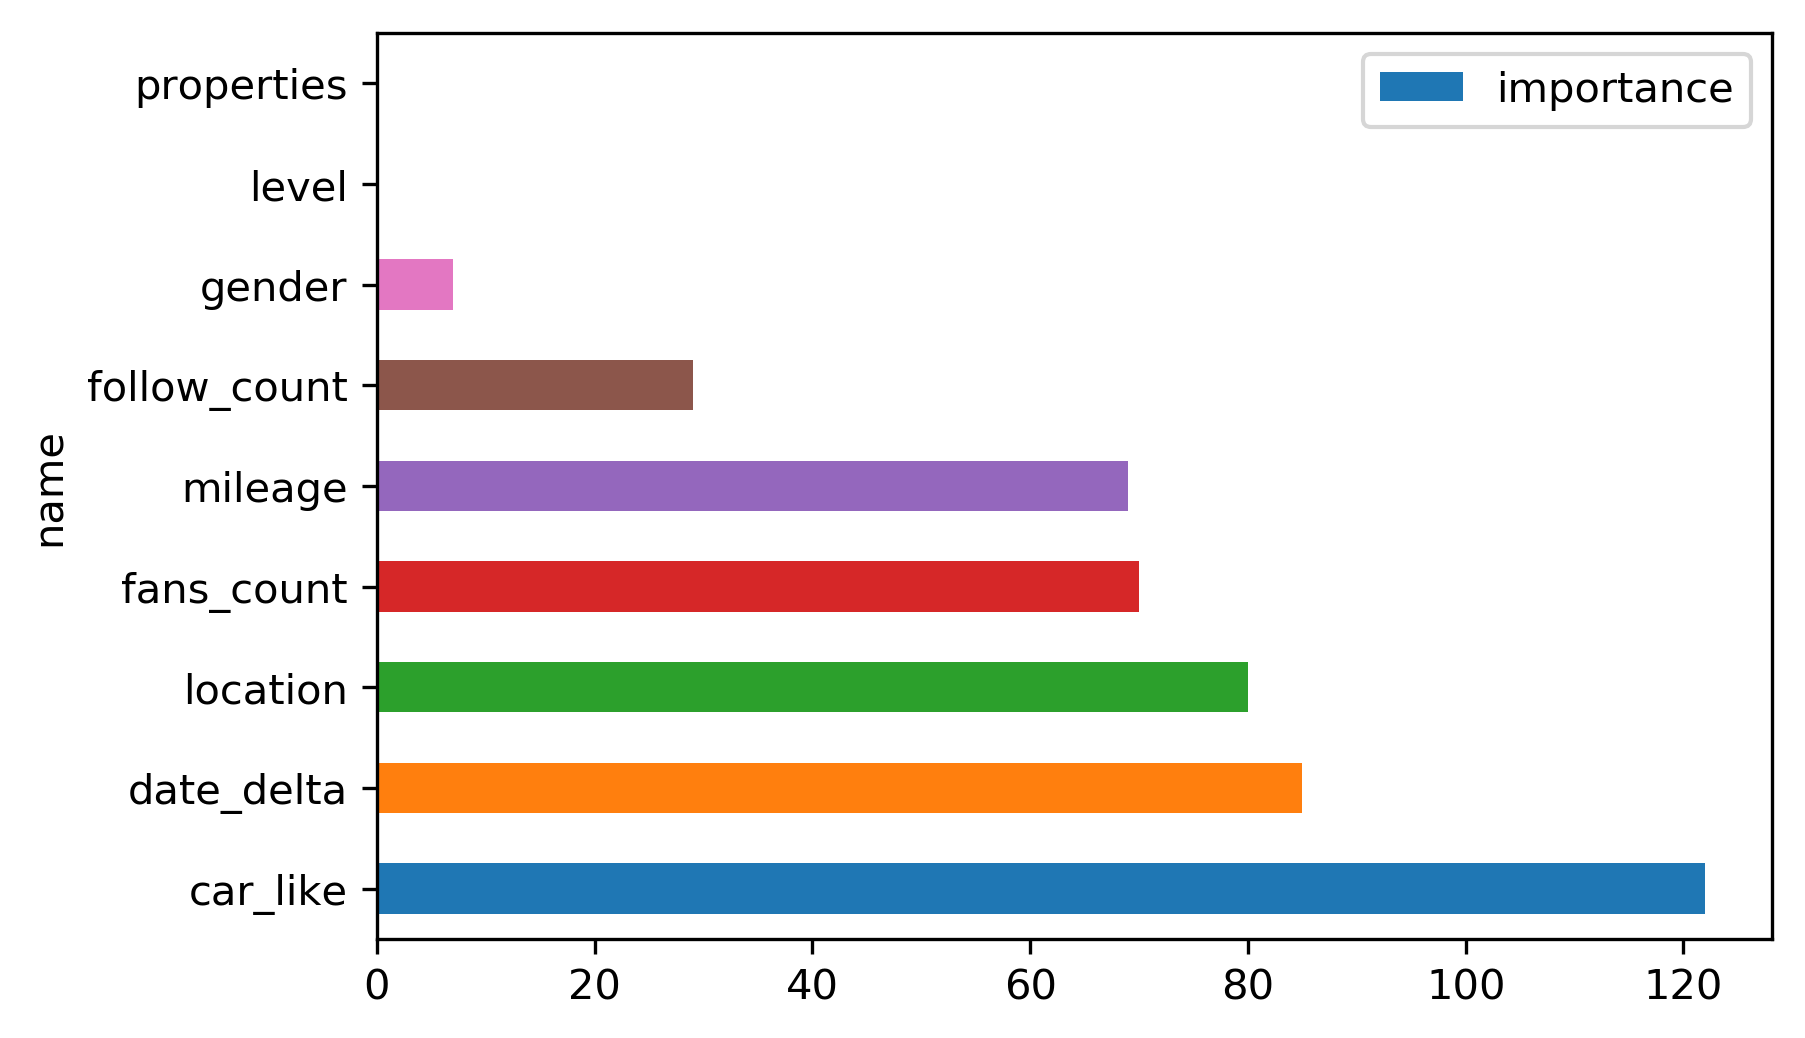

In [357]:
feature_importance = pd.DataFrame({'name':gbm.feature_name(), 'importance':gbm.feature_importance()}).sort_values(by='importance', ascending=False)
feature_importance.to_csv('./feat_importance.csv', index=False)
# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(15, 5)
plt.rcParams['savefig.dpi'] = 200 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
feature_importance.plot(x='name', y='importance',kind='barh')
# plt.savefig('plot123_2.png', dpi=300) 
plt.show()

#### Using best model for Testing 

In [359]:
# load model to predict
print('Load model to predict')
gbm = lgb.Booster(model_file=model_save_path)
                  
y_pred = gbm.predict(x_test)
# print(y_pred[:10])

y_pred = y_pred >= 0.5
# print(y_pred[:10])

from sklearn.metrics import accuracy_score, confusion_matrix
# print(accuracy_score(y_test, y_pred))
print(classification_report(y_true=y_test, y_pred=y_pred))

Load model to predict
             precision    recall  f1-score   support

          0       0.89      0.99      0.94       476
          1       0.86      0.30      0.44        80

avg / total       0.89      0.89      0.87       556

